### Packages

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction import DictVectorizer

import xgboost as xgb

### Load Cleaned Data Set

In [2]:
train_data = pd.read_csv("..\\Data\\train_data_EDA_processed.csv", index_col=0)

In [3]:
train_data.T

,0,1,2,3,4,5,6,7,8,9,...,22073,22074,22075,22076,22077,22078,22079,22080,22081,22082
Patient_Age,2.0,4.0,6.0,12.0,11.0,14.0,3.0,3.0,11.0,4.0,...,13.0,4.0,10.0,0.0,9.0,4.0,8.0,8.0,7.0,11.0
Mother_Gene,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,No,...,Yes,No,No,Yes,No,Yes,No,Yes,Yes,Yes
Father_Gene,No,Yes,No,No,No,No,No,No,No,Yes,...,Yes,No,No,No,Yes,Yes,Yes,No,No,No
Maternal_Gene,Yes,No,No,Yes,NaN,Yes,Yes,Yes,Yes,Yes,...,No,NaN,Yes,Yes,Yes,Yes,No,Yes,Yes,No
Paternal_Gene,No,No,No,No,Yes,No,Yes,Yes,No,Yes,...,Yes,No,Yes,No,Yes,No,Yes,No,Yes,No
Blood_Cell,4.760603,4.910669,4.893297,4.70528,4.720703,5.103188,4.90108,4.964816,5.209058,4.752272,...,4.874635,4.789307,4.64386,4.931758,5.012599,5.258298,4.97422,5.18647,4.858543,4.738067
Mother_Age,NaN,NaN,41.0,21.0,32.0,NaN,NaN,40.0,45.0,44.0,...,44.0,35.0,49.0,NaN,47.0,35.0,NaN,35.0,19.0,32.0
Father_Age,NaN,23.0,22.0,NaN,NaN,NaN,63.0,NaN,44.0,42.0,...,62.0,51.0,NaN,50.0,NaN,64.0,56.0,51.0,NaN,62.0
Status,Alive,Deceased,Alive,Deceased,Alive,Deceased,Alive,Alive,Alive,Alive,...,Alive,Alive,Deceased,Alive,Deceased,Deceased,Alive,Deceased,Alive,Deceased
Respiratory_Rate,Normal (30-60),Tachypnea,Normal (30-60),Tachypnea,Tachypnea,NaN,Normal (30-60),Tachypnea,Tachypnea,Tachypnea,...,Tachypnea,Tachypnea,NaN,Normal (30-60),NaN,Normal (30-60),Normal (30-60),Tachypnea,Tachypnea,Normal (30-60)


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19915 entries, 0 to 22082
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Patient_Age           18672 non-null  float64
 1   Mother_Gene           19915 non-null  object 
 2   Father_Gene           19652 non-null  object 
 3   Maternal_Gene         17510 non-null  object 
 4   Paternal_Gene         19915 non-null  object 
 5   Blood_Cell            19915 non-null  float64
 6   Mother_Age            14719 non-null  float64
 7   Father_Age            14796 non-null  float64
 8   Status                19915 non-null  object 
 9   Respiratory_Rate      18058 non-null  object 
 10  Heart_Rate            18127 non-null  object 
 11  Follow_Up             18070 non-null  object 
 12  Gender                12008 non-null  object 
 13  Birth_Asphyxia        9060 non-null   object 
 14  Autopsy_Birth_Defect  9013 non-null   object 
 15  Birth_Place        

### Road-Map Preprocessing 

I have decided to use XGBoost for modeling and predicting my dataset. The model is proven to work well with structured data and is able to perform modeling using simple constant imputation given my large set of missing values within each feature column. XGBoost decision tree modeling may branch appropriately if it finds something within the imputed missing values as their own catagory.

### Preprocessing Pipeline

In [5]:
# Split the data into feature X and target y
X = train_data.drop(columns="Disorder_Subclass")
y = train_data.Disorder_Subclass

# Label encode target y
le = LabelEncoder()
encoded_y = le.fit_transform(y)

In [6]:
# Train Test Split by 20%
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size = 0.2, random_state=123)

In [7]:
# Grouped numerical columns
num_cols = train_data.select_dtypes('float64').columns

# Grouped categorical columns
cat_cols = train_data.select_dtypes('object').drop(columns="Disorder_Subclass").columns

# Preprocessing for numerical data
num_preprocessor = SimpleImputer(strategy='constant', fill_value=-99)

# Preprocessing for categorical data
cat_preprocessor = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value="-99")),
                                   ('oe', OrdinalEncoder()),
                                   ('ohe', OneHotEncoder())])

# Combine num and cat preprocessor for data frame transformation
preprocessor = ColumnTransformer(
    transformers=[('num_transformer', num_preprocessor, num_cols),
                  ('cat_transformer', cat_preprocessor, cat_cols)])

In [8]:
# Preprocessor Test
pd.DataFrame(preprocessor.fit_transform(X_train, y_train))

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,6.0,4.816182,23.0,32.0,4.0,5.321413,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,13.0,5.005324,28.0,44.0,-99.0,4.334729,1.0,1.0,1.0,-99.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,10.0,4.712737,26.0,-99.0,-99.0,8.649998,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,13.0,5.095956,-99.0,36.0,-99.0,7.548971,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,8.0,4.847835,28.0,56.0,4.0,6.962187,1.0,1.0,-99.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15927,9.0,4.851475,44.0,32.0,4.0,8.191905,1.0,1.0,-99.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
15928,3.0,4.874826,43.0,33.0,4.0,3.000000,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
15929,5.0,4.983901,25.0,46.0,-99.0,3.000000,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
15930,9.0,4.716176,46.0,47.0,4.0,-99.000000,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Initial Out of Box XGB Model1

In [17]:
xgb_model1 = xgb.XGBClassifier(objective='Multi:softmax', eval_metric="mlogloss", use_label_encoder=False, seed=123)

xgb_pipeline1 = Pipeline(steps=[('preprocessor', preprocessor),
                                ('xgb_model', xgb_model1)])

xgb_pipeline1.fit(X_train, y_train)

pred1_train = xgb_pipeline1.predict(X_train)
pred1_test = xgb_pipeline1.predict(X_test)

print(accuracy_score(y_train, pred1_train) * 100)
print(accuracy_score(y_test, pred1_test) * 100)

96.10218428320361
36.50514687421541


In [18]:
# Cross Validation Score
scores = cross_val_score(xgb_pipeline1, X_train, y_train, cv=5, scoring="accuracy")
print("Scores:", scores * 100)
print("Mean:", scores.mean() * 100)
print("Standard Deviation:", scores.std())

Scores: [37.6215877  36.33511139 39.10860013 35.96986817 36.78593848]
Mean: 37.16422117394288
Standard Deviation: 0.01117747159832257


In [19]:
print(classification_report(y_test, pred1_test))

              precision    recall  f1-score   support

           0       0.25      0.07      0.11        29
           1       0.75      0.13      0.22        23
           2       0.40      0.52      0.45       647
           3       0.33      0.24      0.28       346
           4       0.33      0.24      0.28       266
           5       0.26      0.14      0.18       126
           6       0.40      0.41      0.41      1072
           7       0.35      0.38      0.37       901
           8       0.31      0.28      0.29       573

    accuracy                           0.37      3983
   macro avg       0.37      0.27      0.29      3983
weighted avg       0.36      0.37      0.36      3983



The default parameters for XGBoost looks to be overfitting given that the score for the train split has a score around 96, while the test split has a score around 37. This is supported by the cross validation with a mean score of 37. Hyperparameter tuning should reduce the overfitting to predict a better score for the test split, while retaining high accuracy score for the train split.

### Hyperparameter Tuning

In [12]:
D_train = xgb.DMatrix(preprocessor.fit_transform(X_train), label=y_train)
D_test = xgb.DMatrix(preprocessor.fit_transform(X_test), label=y_test)

In [57]:
xgb_model2 = xgb.XGBClassifier(objective='Multi:softmax', eval_metric="mlogloss", use_label_encoder=False, seed=123)

In [58]:
parameters = {
    'max_depth': range(2, 10),
    'n_estimators': range(50, 500),
    'learning_rate': [0.001, 0.010, 0.1, 0.2, 0.5]
}

In [59]:
grid_search = RandomizedSearchCV(
    estimator=xgb_model2,
    param_distributions=parameters,
    scoring = 'f1_macro',
    n_iter = 5,
    cv = 5,
    verbose=True
)

In [60]:
grid_search.fit(preprocessor.fit_transform(X_train), y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[21:13:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:13:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learne

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           objective='Multi:softmax',
                                           predictor=None, random_state=None,
                                 

In [61]:
grid_search.best_params_

{'n_estimators': 213, 'max_depth': 9, 'learning_rate': 0.2}

In [62]:
grid_search.best_score_

0.289893644038698

#### num_boost_round

In [13]:
# Base parameters to be added on with more optimzed paramaters
params = {"objective":'multi:softmax', "num_class":9}

In [14]:
# Perform cross-validation with early stopping: cv_results
cv_results = xgb.cv(dtrain=D_train, metrics="mlogloss", early_stopping_rounds=10, 
                    params=params, nfold=5, num_boost_round=100, as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

    train-mlogloss-mean  train-mlogloss-std  test-mlogloss-mean  \
0              1.964166            0.002204            1.994399   
1              1.809988            0.003484            1.863396   
2              1.697547            0.003237            1.769974   
3              1.607377            0.003635            1.698144   
4              1.534619            0.004417            1.643692   
5              1.475781            0.004329            1.601394   
6              1.424402            0.003985            1.566714   
7              1.379291            0.003477            1.539869   
8              1.339001            0.004103            1.516768   
9              1.303332            0.004490            1.499010   
10             1.269738            0.004626            1.482997   
11             1.239422            0.004740            1.469960   
12             1.211279            0.005154            1.459457   
13             1.185014            0.004152            1.45070

#### max_depth and min_child_weight

In [ ]:
gs_params={}}

#### Learning_Rate

In [17]:
# Create list of eta values and empty list to store final round mlogloss per xgboost model
eta_vals = [0.001, 0.01, 0.1, 10, 100]
best_mlogloss = []

# Systematically vary the eta 
for curr_val in eta_vals:

    params["eta"] = curr_val
    
    # Perform cross-validation: cv_results
    cv_results = xgb.cv(dtrain=D_train, metrics="mlogloss", early_stopping_rounds=5, 
                    params=params, nfold=3, num_boost_round=50, as_pandas=True)
    
    # Append the final round mlogloss to best_mlogloss
    best_mlogloss.append(cv_results["test-mlogloss-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(eta_vals, best_mlogloss)), columns=["eta","mlogloss"]))

       eta   mlogloss
0    0.001   2.175206
1    0.010   2.012427
2    0.100   1.505617
3   10.000   5.070488
4  100.000  20.860645


In [20]:
params["eta"] = 0.1

#### Max_Depth

In [22]:
max_depths = [2, 4, 6, 8, 10, 15, 20]
best_mlogloss = []

# Systematically vary the max_depth
for curr_val in max_depths:

    params["max_depth"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=D_train, metrics="mlogloss", early_stopping_rounds=5, 
                    params=params, nfold=3, num_boost_round=30, as_pandas=True)
    
    # Append the final round mlogloss to best_mlogloss
    best_mlogloss.append(cv_results["test-mlogloss-mean"].tail().values[-1])

# Print the resultant DataFrame
max_depth_df = pd.DataFrame(list(zip(max_depths, best_mlogloss)),columns=["max_depth","best_mlogloss"])
print(max_depth_df)

   max_depth  best_mlogloss
0          2       1.649320
1          4       1.547621
2          6       1.505617
3          8       1.524360
4         10       1.568893
5         15       1.625428
6         20       1.640452


Text(0, 0.5, 'mlogloss')

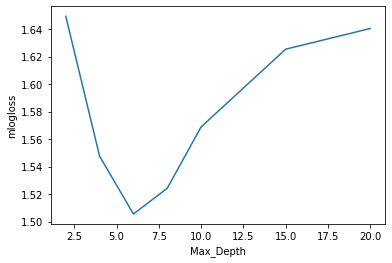

In [27]:
plt.plot(max_depth_df["max_depth"], max_depth_df["best_mlogloss"])
plt.xlabel("Max_Depth")
plt.ylabel("mlogloss")

In [28]:
# Second round max_depth optimization
max_depths = [4, 5, 6, 7, 8]
best_mlogloss = []

# Systematically vary the max_depth
for curr_val in max_depths:

    params["max_depth"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=D_train, metrics="mlogloss", early_stopping_rounds=5, 
                    params=params, nfold=3, num_boost_round=30, as_pandas=True)
    
    # Append the final round mlogloss to best_mlogloss
    best_mlogloss.append(cv_results["test-mlogloss-mean"].tail().values[-1])

# Print the resultant DataFrame
max_depth_df = pd.DataFrame(list(zip(max_depths, best_mlogloss)),columns=["max_depth","best_mlogloss"])
print(max_depth_df)

   max_depth  best_mlogloss
0          4       1.547621
1          5       1.517368
2          6       1.505617
3          7       1.509131
4          8       1.524360


Text(0, 0.5, 'mlogloss')

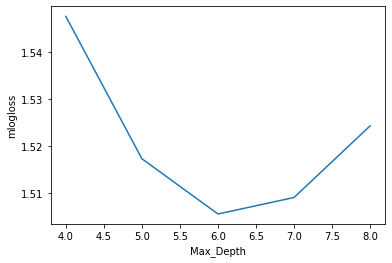

In [29]:
plt.plot(max_depth_df["max_depth"], max_depth_df["best_mlogloss"])
plt.xlabel("Max_Depth")
plt.ylabel("mlogloss")

In [30]:
params["max_depth"] = 6

#### colsample_bytree

In [32]:
colsample_bytree_vals = [0.1, 0.5, 0.8, 1]
best_mlogloss = []

# Systematically vary the hyperparameter value 
for curr_val in colsample_bytree_vals:

    params["colsample_bytree"] = curr_val
    
    # Perform cross-validation
    cv_results = xgb.cv(dtrain=D_train, metrics="mlogloss", early_stopping_rounds=5, 
                    params=params, nfold=3, num_boost_round=30, as_pandas=True)
    
    # Append the final round mlogloss to best_mlogloss
    best_mlogloss.append(cv_results["test-mlogloss-mean"].tail().values[-1])

# Print the resultant DataFrame
print(pd.DataFrame(list(zip(colsample_bytree_vals, best_mlogloss)), columns=["colsample_bytree","best_mlogloss"]))

   colsample_bytree  best_mlogloss
0               0.1       1.762221
1               0.5       1.565242
2               0.8       1.513763
3               1.0       1.505617


In [33]:
params["colsample_bytree"] = 1

In [35]:
params

{'objective': 'multi:softmax',
 'num_class': 9,
 'eta': 0.1,
 'max_depth': 6,
 'colsample_bytree': 1}

In [36]:
xgb_model2 = xgb.XGBClassifier(objective='Multi:softmax', eval_metric="mlogloss", use_label_encoder=False, 
                               num_class=9, eta=0.1, max_depth=6,colsample_bytree=1)

xgb_pipeline2 = Pipeline(steps=[('preprocessor', preprocessor),
                                ('xgb_model', xgb_model2)])

xgb_pipeline2.fit(X_train, y_train)

pred2_train = xgb_pipeline2.predict(X_train)
pred2_test = xgb_pipeline2.predict(X_test)

print(accuracy_score(y_train, pred2_train) * 100)
print(accuracy_score(y_test, pred2_test) * 100)

76.25533517449159
37.911122269646


In [214]:
print(confusion_matrix(y_test, pred1))

[[  2   0   3  16   0   7   1   0   0]
 [  0   3   0   0  13   0   0   0   7]
 [  1   0 336  90   0  19 162  37   2]
 [  2   0 183  84   0  24  45   6   2]
 [  0   1   0   0  65   0  21  62 117]
 [  3   0  60  40   0  18   4   1   0]
 [  0   0 222  20  13   2 442 299  74]
 [  0   0  44   5  41   0 307 343 161]
 [  0   0   2   0  64   0 125 221 161]]


In [215]:
print(classification_report(y_test, pred1))

              precision    recall  f1-score   support

           0       0.25      0.07      0.11        29
           1       0.75      0.13      0.22        23
           2       0.40      0.52      0.45       647
           3       0.33      0.24      0.28       346
           4       0.33      0.24      0.28       266
           5       0.26      0.14      0.18       126
           6       0.40      0.41      0.41      1072
           7       0.35      0.38      0.37       901
           8       0.31      0.28      0.29       573

    accuracy                           0.37      3983
   macro avg       0.37      0.27      0.29      3983
weighted avg       0.36      0.37      0.36      3983



The cross validation score shows that the initial out of the box model performs poorly with a mean of 0.37 accuracy.

In [209]:
le.inverse_transform([0, 1, 2, 3, 4, 5, 6, 7, 8])

array(["Alzheimer's", 'Cancer', 'Cystic fibrosis', 'Diabetes',
       'Hemochromatosis', "Leber's hereditary optic neuropathy",
       'Leigh syndrome', 'Mitochondrial myopathy', 'Tay-Sachs'],
      dtype=object)

<Figure size 1080x1080 with 0 Axes>

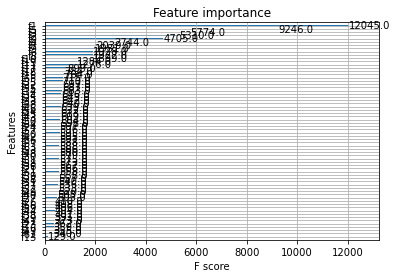

In [165]:
plt.figure(figsize=(15,15))
xgb.plot_importance(xgb_model1)
plt.show()


In [177]:
pd.DataFrame(xgb_model1.feature_importances_).sort_values(by=0, ascending=False)

,0
10,0.064576
9,0.051650
8,0.045588
7,0.034802
6,0.028784
...,...
65,0.010200
13,0.009154
22,0.000000
20,0.000000


In [166]:
importances = pd.DataFrame({
    'Feature': train_data.drop('Disorder_Subclass', axis=1).columns,
    'Importance': xgb_model1.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

ValueError: All arrays must be of the same length

In [126]:
xgb_pipeline3 = Pipeline(steps=[('preprocessor', preprocessor),
                               ('xgb_model', model3)])

xgb_pipeline3.fit(X_train, y_train)

pred3 = xgb_pipeline3.predict(X_test)
print("Accuracy for model 3: %.2f" % (accuracy_score(y_test, pred3) * 100))

[13:12:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:12:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy for model 3: 37.26


In [128]:
print("Accuracy for model 3: %.2f" % (accuracy_score(y_test, pred3) * 100))

Accuracy for model 3: 37.26


In [89]:
gbm_param_grid = {
    'clf__learning_rate': np.arange(0.05, 1, 0.05),
    'clf__max_depth': np.arange(3, 10, 1),
    'clf__n_estimators': np.arange(50, 100, 50)
}

In [87]:
randomized_roc_auc = RandomizedSearchCV(estimator=xgb_pipeline, n_iter=2, verbose=1, 
                                        param_distributions=gbm_param_grid, scoring="roc_auc", cv=2)

In [90]:
randomized_roc_auc.fit(X, encoded_y)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


ValueError: Invalid parameter clf for estimator Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  SimpleImputer(fill_value=-99,
                                                                strategy='constant'),
                                                  Index(['Patient_Age', 'Blood_Cell', 'Mother_Age', 'Father_Age',
       'Previous_Abortions', 'White_Blood_Cell', 'Symptom_1', 'Symptom_2',
       'Symptom_3', 'Symptom_4', 'Symptom_5'],
      dtype='object')),
                                                 ('cat_transformer',
                                                  Pipeline(steps=[('im...
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=6, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=None, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))]). Check the list of available parameters with `estimator.get_params().keys()`.

In [90]:
estimator.get_params().keys()

NameError: name 'estimator' is not defined

In [68]:
cross_val_scores

array([nan, nan, nan])

In [20]:
y_pred = xgb_pipeline.predict(X_test)

In [21]:
acc = accuracy_score(y_test, y_pred)
acc

0.36505146874215416

In [65]:
le.inverse_transform(y_pred)

array(['Leigh syndrome', 'Mitochondrial myopathy', 'Cystic fibrosis', ...,
       'Tay-Sachs', 'Diabetes', 'Cystic fibrosis'], dtype=object)

In [29]:
dmatrix = xgb.DMatrix(data=X_pre, label=encoded_y)

In [30]:

xgb.plot_importance(model_pipeline)

ValueError: tree must be Booster, XGBModel or dict instance

In [32]:
print(dmatrix)

In [ ]:
sudo apt-get install graphviz